In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

### Load validation predicted probabilities

In [4]:
main_dir = '/tf/notebooks/'

In [5]:
probs_path = main_dir+'final-project/Classification/data/ethnicity'

In [6]:
val_pred_probs_mlp_ngram = np.load(os.path.join(probs_path, 'val_pred_probs_mlp_ngram.npy'))
val_pred_probs_cnn = np.load(os.path.join(probs_path, 'val_pred_probs_cnn.npy'))
val_pred_probs_cnn_aggr_chunk = np.load(os.path.join(probs_path, 'val_pred_probs_cnn_aggr_chunk.npy'))

In [7]:
len(val_pred_probs_mlp_ngram), len(val_pred_probs_cnn), len(val_pred_probs_cnn_aggr_chunk)

(62840, 62840, 62840)

In [8]:
with open(os.path.join(probs_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(probs_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)
with open(os.path.join(probs_path, 'val_list'), 'rb') as fp:
    val_list = pickle.load(fp)

In [9]:
len(val_ids), len(val_target), len(val_list)

(62840, 62840, 62840)

In [10]:
val_preds_mlp_ngram = val_pred_probs_mlp_ngram > 0.5
val_preds_cnn = val_pred_probs_cnn > 0.5
val_preds_cnn_aggr_chunk = val_pred_probs_cnn_aggr_chunk > 0.5

In [11]:
sum(val_preds_mlp_ngram), sum(val_preds_cnn), sum(val_preds_cnn_aggr_chunk)

(array([27154]), array([27678]), 27686)

In [12]:
np.mean(val_target==val_preds_mlp_ngram.flatten())

0.7552196053469128

In [13]:
classes = ['White', 'NonWhite']

Confusion matrix, without normalization
[[25862  5558]
 [ 9824 21596]]
              precision    recall  f1-score   support

       White       0.72      0.82      0.77     31420
    NonWhite       0.80      0.69      0.74     31420

   micro avg       0.76      0.76      0.76     62840
   macro avg       0.76      0.76      0.75     62840
weighted avg       0.76      0.76      0.75     62840



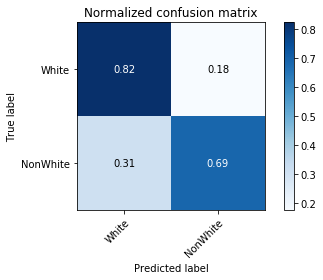

In [14]:
explore_data.plot_confusion_matrix(val_target, val_preds_mlp_ngram, classes, normalize=True)

In [15]:
np.mean(val_target==val_preds_cnn.flatten())

0.7358370464672184

Confusion matrix, without normalization
[[24991  6429]
 [10171 21249]]
              precision    recall  f1-score   support

       White       0.71      0.80      0.75     31420
    NonWhite       0.77      0.68      0.72     31420

   micro avg       0.74      0.74      0.74     62840
   macro avg       0.74      0.74      0.73     62840
weighted avg       0.74      0.74      0.73     62840



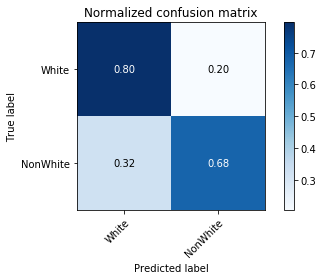

In [16]:
explore_data.plot_confusion_matrix(val_target, val_preds_cnn, classes, normalize=True)

In [17]:
np.mean(val_target==val_preds_cnn_aggr_chunk.flatten())

0.74484404837683

Confusion matrix, without normalization
[[25270  6150]
 [ 9884 21536]]
              precision    recall  f1-score   support

       White       0.72      0.80      0.76     31420
    NonWhite       0.78      0.69      0.73     31420

   micro avg       0.74      0.74      0.74     62840
   macro avg       0.75      0.74      0.74     62840
weighted avg       0.75      0.74      0.74     62840



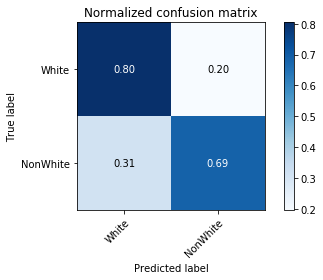

In [18]:
explore_data.plot_confusion_matrix(val_target, val_preds_cnn_aggr_chunk, classes, normalize=True)

In [19]:
descr_df = pd.read_csv(main_dir+'final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.reset_index(inplace=True)
descr_df.shape

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(62840, 17)

In [20]:
descr_df.head()

,speech_id,date,char_count,word_count,speakerid,Party,Congress,Chamber,State,Ethnicity,Age,Age_lt_med,NonWhite,Female,speaker,Full Name,match
0,1010243717,19901025,870,166,101110870.0,D,101,H,TX,B,49.0,1.0,1.0,0.0,Mr. WASHINGTON,"WASHINGTON, CRAIG",exact
1,1120097305,20120416,1186,197,112116570.0,R,112,H,OH,AAPIA,54.0,1.0,1.0,0.0,Mr. AUSTRIA,"AUSTRIA, STEVE",fuzzy
2,1020183502,19920630,257,40,102111850.0,D,102,H,TX,H,76.0,0.0,1.0,0.0,Mr. GONZALEZ,"GONZALEZ, HENRY",exact
3,1080187463,20041001,2689,420,108115260.0,D,108,H,MD,B,53.0,1.0,1.0,0.0,Mr. WYNN,"WYNN, ALBERT",fuzzy
4,1090010764,20050309,7723,1156,109116411.0,D,109,S,HI,AAPIA,82.0,0.0,1.0,0.0,Mr. AKAKA,"AKAKA, DANIEL",exact


In [21]:
pred_df = pd.DataFrame({'ids': np.asarray(val_ids, dtype=np.int64), 
                        'pred_probs_mlp_ngram': val_pred_probs_mlp_ngram.flatten(), 
                        'pred_probs_cnn': val_pred_probs_cnn.flatten(),
                        'pred_probs_cnn_chunk': val_pred_probs_cnn_aggr_chunk.flatten()})
pred_df.shape

(62840, 4)

In [22]:
pred_df.head()

,ids,pred_probs_cnn,pred_probs_cnn_chunk,pred_probs_mlp_ngram
0,1010243717,0.489893,0.403256,0.404872
1,1120097305,0.854216,0.566222,0.942785
2,1020183502,0.367378,0.425271,0.294390
3,1080187463,0.156427,0.421413,0.944420
4,1090010764,0.693374,0.547798,0.949667


In [23]:
descr_pred_df = descr_df.merge(pred_df, left_on='speech_id', right_on='ids')
descr_pred_df.shape

(62840, 21)

In [24]:
preds = [
    'pred_probs_mlp_ngram',
    'pred_probs_cnn', 
    'pred_probs_cnn_chunk'
]

In [25]:
descr_pred_df[preds+['Ethnicity']].groupby('Ethnicity').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
Ethnicity,,,
AAPIA,0.618414,0.600247,0.563464
B,0.701784,0.659444,0.609200
B/AAPIA,0.648916,0.648559,0.596443
B/H,0.706941,0.658559,0.606603
H,0.638925,0.628658,0.582228
H/ME,0.263064,0.266897,0.359864
ME,0.557911,0.509696,0.497224
W,0.286154,0.316255,0.387114


In [26]:
descr_pred_df[preds+['NonWhite']].groupby('NonWhite').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
NonWhite,,,
0.0,0.286154,0.316255,0.387114
1.0,0.656335,0.624964,0.582987


In [27]:
preds_combo = []
for i in range(1, len(preds)+1):
    preds_combo.extend(list(itertools.combinations(preds, i)))
len(preds_combo)

7

In [28]:
preds_combo_results = []
for i in range(len(preds_combo)):
    temp = descr_pred_df[list(preds_combo[i])]
    avg = temp.mean(axis=1)
    avg_pred = avg > 0.5
    result = np.mean(avg_pred==descr_pred_df['NonWhite'])
    preds_combo_results.append((preds_combo[i], result))

In [29]:
preds_combo_results = sorted(preds_combo_results, key=lambda x: -x[1])
preds_combo_results

[(('pred_probs_mlp_ngram', 'pred_probs_cnn', 'pred_probs_cnn_chunk'),
  0.7670432845321451),
 (('pred_probs_mlp_ngram', 'pred_probs_cnn_chunk'), 0.7661043921069383),
 (('pred_probs_mlp_ngram', 'pred_probs_cnn'), 0.7642584341183959),
 (('pred_probs_mlp_ngram',), 0.7552196053469128),
 (('pred_probs_cnn', 'pred_probs_cnn_chunk'), 0.7493793761935074),
 (('pred_probs_cnn_chunk',), 0.74484404837683),
 (('pred_probs_cnn',), 0.7358370464672184)]

In [30]:
descr_pred_df['pred_probs_combo'] = descr_pred_df[list(preds_combo_results[0][0])].mean(axis=1)
descr_pred_df['pred_combo'] = descr_pred_df['pred_probs_combo'] > 0.5
np.mean(val_target==descr_pred_df['pred_combo'].values.flatten())

0.7670432845321451

In [31]:
model_types = [
    (val_pred_probs_mlp_ngram, 'MLP ngram'),
    (val_pred_probs_cnn, 'CNN'), 
    (val_pred_probs_cnn_aggr_chunk, 'CNN chunk')
]

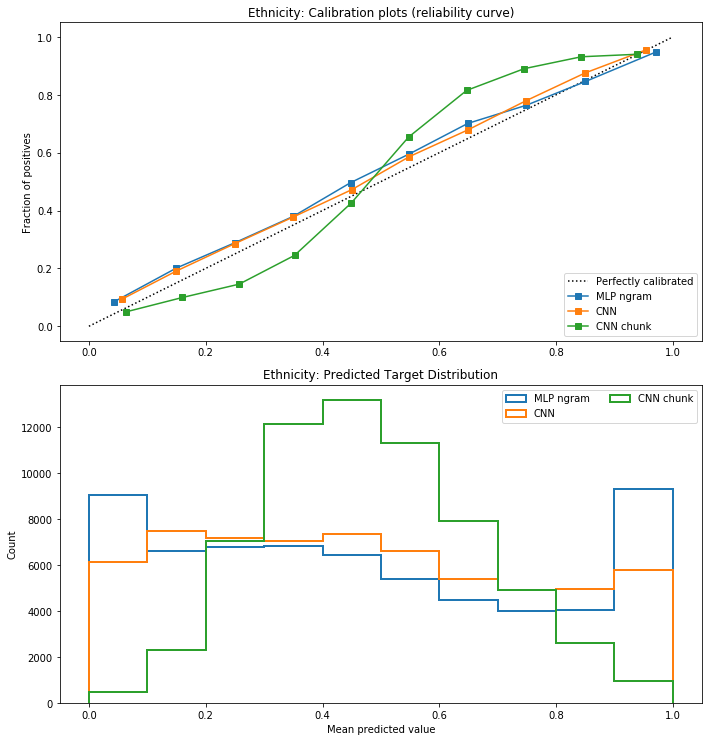

In [32]:
reload(explore_data)
explore_data.plot_compare_calibration_curves(val_target, model_types, 'Ethnicity')

### Save the main dataframe

In [33]:
keep_cols = ['speech_id',
 'date',
 'char_count',
 'word_count',
 'speakerid',
 'Party',
 'Congress',
 'Chamber',
 'State',
 'Ethnicity',
 'Age',
 'Age_lt_med',
 'NonWhite',
 'Female',
 'speaker',
 'Full Name',
 'match',
 'ids',
 'pred_probs_combo',
 'pred_combo']

In [34]:
descr_pred_df[keep_cols].to_pickle(os.path.join(probs_path, 'ethnicity_preds.pkl'))

### Evaluating final predictions

Confusion matrix, without normalization
[[26159  5261]
 [ 9378 22042]]
              precision    recall  f1-score   support

       White       0.74      0.83      0.78     31420
    NonWhite       0.81      0.70      0.75     31420

   micro avg       0.77      0.77      0.77     62840
   macro avg       0.77      0.77      0.77     62840
weighted avg       0.77      0.77      0.77     62840



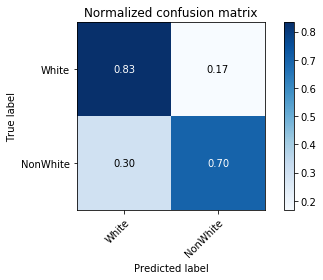

In [35]:
explore_data.plot_confusion_matrix(val_target, descr_pred_df['pred_combo'], classes, normalize=True)

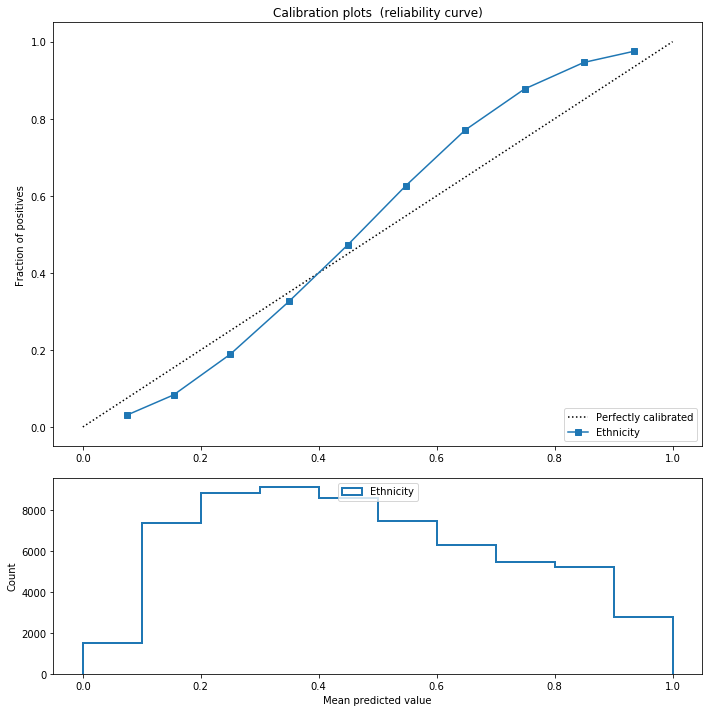

In [36]:
explore_data.plot_calibration_curve(val_target, descr_pred_df['pred_probs_combo'], 'Ethnicity')

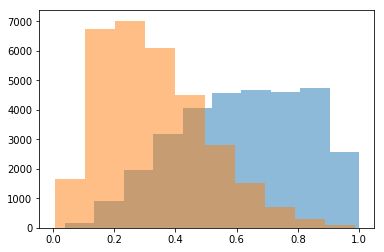

In [96]:
_=plt.hist(descr_pred_df[descr_pred_df.NonWhite==1]['pred_probs_combo'], alpha=0.5)
_=plt.hist(descr_pred_df[descr_pred_df.NonWhite==0]['pred_probs_combo'], alpha=0.5)
plt.show()

In [37]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(descr_pred_df['pred_probs_combo'], 
                                   val_ids, 
                                   descr_df.set_index('speech_id'))

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.175939            0.5  58.427562  0.690738   0.694876    376.978469


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.41,0.39,0.99,0.77,0.66,1.08
0.6,0.94,1.09,0.99,1.04,1.21,0.86
1.0,1.84,1.75,1.01,1.29,1.30,1.00


In [38]:
reload(explore_data)
explore_data.compare_ngrams(val_list, descr_pred_df['pred_probs_combo'], 
                            ngram_range=(1, 1),
                            top_k=20)


Top 20 ngrams by differentiating score:


,ngram,<0.4,<0.6,<1.0,score
0,black,411.0,495.0,5525.0,716.0
1,african,165.0,259.0,3246.0,524.0
2,caucus,335.0,215.0,2287.0,496.0
3,consume,465.0,1119.0,1462.0,469.0
4,senators,4338.0,793.0,1069.0,343.0
5,civil,1284.0,1312.0,3860.0,326.0
6,minorities,119.0,145.0,1249.0,321.0
7,gentlewoman,402.0,676.0,1586.0,320.0
8,congressional,2665.0,1567.0,4543.0,317.0
9,printed,1711.0,440.0,307.0,312.0


### Adding topics

In [39]:
ldadata_path = main_dir+'final-project/LDA/data/'
all_speeches_topics_df = pd.read_pickle(ldadata_path+'speeches_topics_ethnicity_36')
all_speeches_topics_df.Speech_id = all_speeches_topics_df.Speech_id.astype('int')
all_speeches_topics_df.shape

(62840, 7)

In [40]:
topic_pred_df = descr_pred_df.merge(all_speeches_topics_df, 
                               left_on='speech_id',
                               right_on='Speech_id')
topic_pred_df.shape

(62840, 30)

In [41]:
topic_names = pd.read_csv(os.path.join(ldadata_path, 'ethnicity_topics.txt'), sep="|", header=None, names=["Prim_Topic", "Prim_Topic_Name"])

In [42]:
topic_pred_df = topic_pred_df.merge(topic_names, on='Prim_Topic')

## Congressperson level analysis

In [43]:
speaker_df = topic_pred_df[['Full Name', 'Party', 'State', 'Female', 'NonWhite', 'Age', 'pred_probs_combo', 'speech_id', 'Topic_Count']]\
                .groupby(['Full Name', 'Party', 'State', 'Female', 'NonWhite'])\
                .agg({'pred_probs_combo':['mean'], 'Age': ['mean'], 'speech_id': ['count'], 'Topic_Count': ['mean']})
speaker_df.columns = ['_'.join(col) for col in speaker_df.columns]
speaker_df.reset_index(inplace=True)
speaker_df['NonWhite_pred'] = speaker_df.pred_probs_combo_mean > 0.5
speaker_df.shape

(1702, 10)

In [44]:
speaker_df.NonWhite.mean()

0.13337250293772032

In [45]:
np.mean(speaker_df.NonWhite==speaker_df.NonWhite_pred)

0.8683901292596945

Confusion matrix, without normalization
[[1284  191]
 [  33  194]]
              precision    recall  f1-score   support

       White       0.97      0.87      0.92      1475
    NonWhite       0.50      0.85      0.63       227

   micro avg       0.87      0.87      0.87      1702
   macro avg       0.74      0.86      0.78      1702
weighted avg       0.91      0.87      0.88      1702



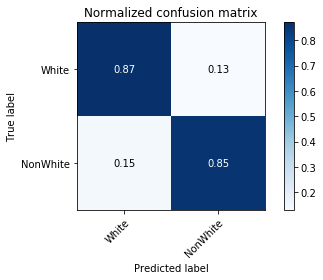

In [46]:
explore_data.plot_confusion_matrix(speaker_df.NonWhite, speaker_df.NonWhite_pred, classes, normalize=True)

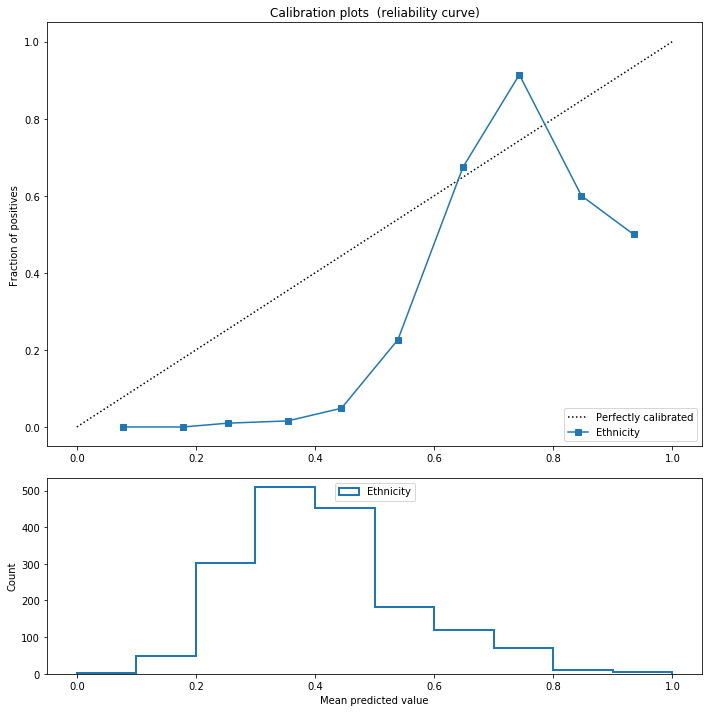

In [47]:
explore_data.plot_calibration_curve(speaker_df.NonWhite, speaker_df['pred_probs_combo_mean'], 'Ethnicity')

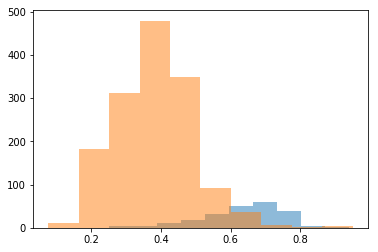

In [97]:
_=plt.hist(speaker_df[speaker_df.NonWhite==1]['pred_probs_combo_mean'], alpha=0.5)
_=plt.hist(speaker_df[speaker_df.NonWhite==0]['pred_probs_combo_mean'], alpha=0.5)
plt.show()

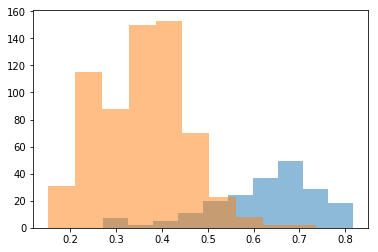

In [98]:
_=plt.hist(speaker_df[(speaker_df.NonWhite==1) & (speaker_df.speech_id_count>speaker_df.speech_id_count.median())]['pred_probs_combo_mean'], alpha=0.5)
_=plt.hist(speaker_df[(speaker_df.NonWhite==0) & (speaker_df.speech_id_count>speaker_df.speech_id_count.median())]['pred_probs_combo_mean'], alpha=0.5)
plt.show()

### Checking misclassifications

In [48]:
speaker_df[(speaker_df.NonWhite==0) & (speaker_df.NonWhite_pred==1)].speech_id_count.describe()

count    191.000000
mean       8.062827
std       11.302828
min        1.000000
25%        2.000000
50%        4.000000
75%        9.000000
max       78.000000
Name: speech_id_count, dtype: float64

In [49]:
speaker_df[(speaker_df.NonWhite==1) & (speaker_df.NonWhite_pred==0)].speech_id_count.describe()

count     33.000000
mean      94.030303
std       85.695130
min        1.000000
25%       29.000000
50%       79.000000
75%      141.000000
max      375.000000
Name: speech_id_count, dtype: float64

In [50]:
speaker_df[speaker_df.speech_id_count==speaker_df.speech_id_count.max()]

,Full Name,Party,State,Female,NonWhite,Age_mean,Topic_Count_mean,speech_id_count,pred_probs_combo_mean,NonWhite_pred
1111,"MITCHELL, GEORGE",D,ME,0.0,1.0,57.953478,4.980193,2171,0.554532,True


In [51]:
speaker_df[(speaker_df.NonWhite==0) & (speaker_df.NonWhite_pred==1)].sort_values(by='pred_probs_combo_mean', ascending=False).head()

,Full Name,Party,State,Female,NonWhite,Age_mean,Topic_Count_mean,speech_id_count,pred_probs_combo_mean,NonWhite_pred
1190,"OROURKE, BETO",D,TX,0.0,0.0,42.0,6.0,1,0.950278,True
567,"FRANKEL, LOIS",D,FL,1.0,0.0,68.0,8.0,1,0.937474,True
717,"HEFTEL, CECIL",D,HI,0.0,0.0,60.0,10.0,1,0.895615,True
1251,"PITTENGER, ROBERT",R,NC,0.0,0.0,68.0,2.0,1,0.880507,True
371,"CURSON, DAVID",D,MI,0.0,0.0,64.0,6.0,1,0.873734,True


In [52]:
descr_pred_df[descr_pred_df['Full Name']=='OROURKE, BETO'].speech_id

59988    1130101735
Name: speech_id, dtype: int64

In [53]:
val_list[val_ids.index('1130101735')]

'Mr. Speaker. I rise today to recognize Maestro Phillip Gabriel Garcia. founder of the El Paso Youth Symphony Orchestra (EPYSO). As the conductor and head of operations for this organization. Maestro Garcia provides a valuable service to the children of El Paso and its citizens. Through the development of "The Band Against Bullying Tour". the EPYSO built a bridge between music and social justice awareness. EPYSO helped raise consciousness of the negative effects that bullying has on the victims and the communitys quality of life with their performances throughout El Paso. By using music as a means to educate the community. Maestro Garcia demonstrates his creative and passionate work ethic to improve his community. With over 200 concerts performed. EPYSO gives kids the opportunity to see how music can positively reinforce their selfesteem through personal achievements as musicians and performances to their community. While performing at the Child Crisis Center. the Battered Women Shelte

In [54]:
keep_cols = [
    'date',
    'word_count',
    'Party',
    'Congress',
    'Chamber',
    'State',
    'Ethnicity',
    'Age',
    'Female',
    'Full Name',
    'pred_probs_mlp_ngram',
    'pred_probs_cnn',
    'pred_probs_cnn_chunk',
    'pred_probs_combo',
    'Prim_Topic_Name',
    'Prim_Topic_Contrib',
    'Sec_Topic',
    'Sec_Topic_Contrib',
]

In [55]:
topic_pred_df[keep_cols][topic_pred_df['Full Name']=='OROURKE, BETO'].T

,58022
date,20140620
word_count,278
Party,D
Congress,113
Chamber,H
State,TX
Ethnicity,W
Age,42
Female,0
Full Name,"OROURKE, BETO"


In [56]:
speaker_df[['pred_probs_combo_mean','NonWhite','NonWhite_pred', 'Full Name', 'speech_id_count']]\
            .groupby(['NonWhite','NonWhite_pred'])\
            .agg({'pred_probs_combo_mean': ['min','mean','max'],
                  'Full Name': ['count'],
                  'speech_id_count': ['sum']})

Full Name pred_probs_combo_mean                      \
                           count                   min      mean       max   
NonWhite NonWhite_pred                                                       
0.0      False              1284              0.076318  0.353600  0.499923   
         True                191              0.500077  0.574785  0.950278   
1.0      False                33              0.251377  0.412481  0.497635   
         True                194              0.501571  0.669511  0.939788   

                       speech_id_count  
                                   sum  
NonWhite NonWhite_pred                  
0.0      False                   29880  
         True                     1540  
1.0      False                    3103  
         True                    28317

#### Checking individual cases

In [57]:
speaker_df.speech_id_count.median()

11.0

In [58]:
speaker_med_df = speaker_df[speaker_df.speech_id_count > speaker_df.speech_id_count.median()]
speaker_med_df.shape

(844, 10)

In [59]:
tp = np.argmax(speaker_med_df[speaker_med_df.NonWhite==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite==1].iloc[tp]

Full Name                JEFFRIES, HAKEEM
Party                                   D
State                                  NY
Female                                  0
NonWhite                                1
Age_mean                          44.6136
Topic_Count_mean                  8.26136
speech_id_count                        88
pred_probs_combo_mean            0.816514
NonWhite_pred                        True
Name: 806, dtype: object

In [60]:
tn = np.argmin(speaker_med_df[speaker_med_df.NonWhite==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite==0].iloc[tn]

Full Name                CORKER, BOB
Party                              R
State                             TN
Female                             0
NonWhite                           0
Age_mean                     59.6667
Topic_Count_mean                6.75
speech_id_count                   12
pred_probs_combo_mean       0.151939
NonWhite_pred                  False
Name: 336, dtype: object

In [61]:
fp = np.argmax(speaker_med_df[speaker_med_df.NonWhite==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite==0].iloc[fp]

Full Name                BORDALLO, MADELEINE
Party                                      D
State                                     GU
Female                                     1
NonWhite                                   0
Age_mean                                75.4
Topic_Count_mean                         7.4
speech_id_count                           20
pred_probs_combo_mean               0.737122
NonWhite_pred                           True
Name: 150, dtype: object

In [62]:
fn = np.argmin(speaker_med_df[speaker_med_df.NonWhite==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite==1].iloc[fn]

Full Name                ABDNOR, JAMES
Party                                R
State                               SD
Female                               0
NonWhite                             1
Age_mean                       61.5444
Topic_Count_mean               6.99444
speech_id_count                    180
pred_probs_combo_mean         0.270671
NonWhite_pred                    False
Name: 0, dtype: object

In [63]:
topic_share = topic_pred_df[['Prim_Topic_Name', 'speech_id']].groupby('Prim_Topic_Name').count() / topic_pred_df.shape[0]
topic_share.columns = ['topic_share']
topic_share.reset_index(inplace=True)
topic_share.shape

(36, 2)

In [64]:
pred_share = topic_pred_df[['NonWhite', 'pred_combo', 'speech_id']]\
                    .groupby(['NonWhite', 'pred_combo'])\
                    .count()\
                    .reset_index()
pred_share.rename(columns = {'speech_id': 'pred_speech_cnt'}, inplace=True)
pred_share

,NonWhite,pred_combo,pred_speech_cnt
0,0.0,False,26159
1,0.0,True,5261
2,1.0,False,9378
3,1.0,True,22042


In [65]:
topic_pred_share = topic_pred_df[['Prim_Topic_Name', 'NonWhite', 'pred_combo', 'speech_id']]\
                    .groupby(['Prim_Topic_Name', 'NonWhite', 'pred_combo'])\
                    .count()\
                    .reset_index()
topic_pred_share.rename(columns = {'speech_id': 'topic_pred_speech_cnt'}, inplace=True)
topic_pred_share = topic_pred_share.merge(topic_share, on='Prim_Topic_Name').merge(pred_share, on=['NonWhite', 'pred_combo'])
topic_pred_share['topic_pred_share'] = topic_pred_share.topic_pred_speech_cnt/topic_pred_share.pred_speech_cnt
topic_pred_share['topic_pred_share_index'] = topic_pred_share.topic_pred_share/topic_pred_share.topic_share
topic_pred_share.shape

(144, 8)

In [66]:
topic_pred_share[(topic_pred_share.NonWhite==1) & (topic_pred_share.pred_combo==1)].sort_values(by='topic_pred_share_index', ascending=False).head()

,Prim_Topic_Name,NonWhite,pred_combo,topic_pred_speech_cnt,topic_share,pred_speech_cnt,topic_pred_share,topic_pred_share_index
109,Art and Culture,1.0,True,211,0.005188,22042,0.009573,1.845228
127,Great Nation,1.0,True,1100,0.027403,22042,0.049905,1.821146
118,Economy,1.0,True,577,0.015738,22042,0.026177,1.663277
111,Children's and Family Programs,1.0,True,684,0.018682,22042,0.031032,1.661014
116,Common Congressional Phrases 5,1.0,True,359,0.010041,22042,0.016287,1.621998


In [67]:
topic_pred_share[(topic_pred_share.NonWhite==0) & (topic_pred_share.pred_combo==0)].sort_values(by='topic_pred_share_index', ascending=False).head()

,Prim_Topic_Name,NonWhite,pred_combo,topic_pred_speech_cnt,topic_share,pred_speech_cnt,topic_pred_share,topic_pred_share_index
17,Foreign Trade,0.0,False,345,0.009246,26159,0.013189,1.426455
7,Common Congressional Phrases 4,0.0,False,931,0.026003,26159,0.035590,1.368714
13,Energy,0.0,False,369,0.010630,26159,0.014106,1.326982
28,Random Verbs 2,0.0,False,4383,0.127371,26159,0.167552,1.315465
31,Taxes and Budget,0.0,False,1364,0.041041,26159,0.052143,1.270510


In [68]:
topic_pred_share[(topic_pred_share.NonWhite==0) & (topic_pred_share.pred_combo==1)].sort_values(by='topic_pred_share_index', ascending=False).head(5)

,Prim_Topic_Name,NonWhite,pred_combo,topic_pred_speech_cnt,topic_share,pred_speech_cnt,topic_pred_share,topic_pred_share_index
66,State and Local,0.0,True,32,0.003581,5261,0.006082,1.698773
58,Intelligence and Security,0.0,True,118,0.013542,5261,0.022429,1.656229
71,Women's and Labor Rights,0.0,True,77,0.009071,5261,0.014636,1.613555
39,Children's and Family Programs,0.0,True,150,0.018682,5261,0.028512,1.526128
44,Common Congressional Phrases 5,0.0,True,80,0.010041,5261,0.015206,1.514358


In [69]:
topic_pred_share[(topic_pred_share.NonWhite==1) & (topic_pred_share.pred_combo==0)].sort_values(by='topic_pred_share_index', ascending=False).head(5)

,Prim_Topic_Name,NonWhite,pred_combo,topic_pred_speech_cnt,topic_share,pred_speech_cnt,topic_pred_share,topic_pred_share_index
104,The Navy,1.0,False,24,0.001194,9378,0.002559,2.144253
85,Energy,1.0,False,154,0.010630,9378,0.016421,1.544793
74,Bankruptcy and Liability,1.0,False,16,0.001178,9378,0.001706,1.448819
89,Foreign Trade,1.0,False,122,0.009246,9378,0.013009,1.407050
101,Scientific Research,1.0,False,66,0.005092,9378,0.007038,1.382038


## Congress level analysis

In [70]:
congress_df = descr_pred_df[['Congress', 'NonWhite', 'pred_probs_combo', 'pred_combo']]\
                .groupby('Congress')\
                .agg({'NonWhite': ['mean', 'sum'], 'pred_combo': ['mean']})\
                .reset_index()
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df['Prediction_balance'] = congress_df.pred_combo_mean / congress_df.NonWhite_mean
congress_df.shape

(18, 5)

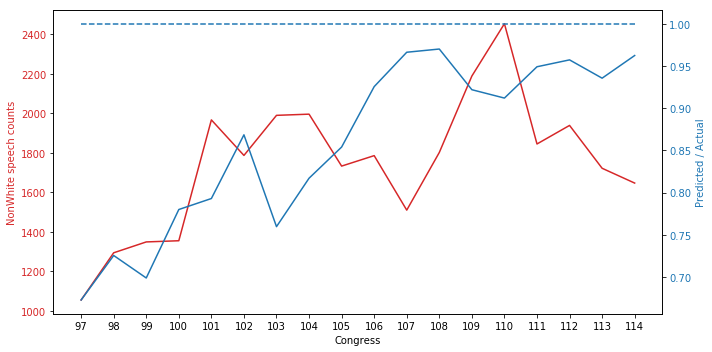

In [71]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Congress')
ax1.set_ylabel('NonWhite speech counts', color=color)
ax1.plot(congress_df.Congress_, congress_df.NonWhite_sum, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted / Actual', color=color)  # we already handled the x-label with ax1
ax2.plot(congress_df.Congress_, congress_df.Prediction_balance, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.hlines(y=1,xmin=97,xmax=114, color=color, linestyles='dashed')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(range(97,115))
plt.show()

### Error analysis

In [72]:
ttl_mispred = descr_pred_df[(descr_pred_df.NonWhite==1) & (descr_pred_df.pred_combo==0)].shape[0] + descr_pred_df[(descr_pred_df.NonWhite==0) & (descr_pred_df.pred_combo==1)].shape[0]
ttl_mispred

14639

In [73]:
false_positives = descr_pred_df[(descr_pred_df.NonWhite==0) & (descr_pred_df.pred_combo==1)]
false_positives.pred_probs_combo.describe()

count    5261.000000
mean        0.618179
std         0.099197
min         0.500023
25%         0.537979
50%         0.593304
75%         0.671718
max         0.985661
Name: pred_probs_combo, dtype: float64

In [74]:
fp_binned = np.digitize(false_positives.pred_probs_combo, [0.5, 0.6, 1])
np.unique(fp_binned, return_counts=True)[1]/ttl_mispred

array([0.19072341, 0.16865906])

In [75]:
false_negatives = descr_pred_df[(descr_pred_df.NonWhite==1) & (descr_pred_df.pred_combo==0)]
false_negatives.pred_probs_combo.describe()

count    9378.000000
mean        0.364439
std         0.096686
min         0.039697
25%         0.300324
50%         0.381832
75%         0.443932
max         0.499994
Name: pred_probs_combo, dtype: float64

In [76]:
fn_binned = np.digitize(false_negatives.pred_probs_combo, [0, 0.4, 0.5])
np.unique(fn_binned, return_counts=True)[1]/ttl_mispred

array([0.36300294, 0.27761459])

In [77]:
# check sum
np.sum(np.unique(fp_binned, return_counts=True)[1] + np.unique(fn_binned, return_counts=True)[1]) - ttl_mispred

0

In [78]:
confusion = descr_pred_df[(descr_pred_df.pred_probs_combo>0.4) & (descr_pred_df.pred_probs_combo<0.6)]
confusion.shape

(16082, 23)

In [79]:
pred_mlp_ngram = list((confusion.pred_probs_mlp_ngram > 0.5) == confusion.NonWhite)
pred_cnn = list((confusion.pred_probs_cnn > 0.5) == confusion.NonWhite)
pred_cnn_chunk = list((confusion.pred_probs_cnn_chunk > 0.5) == confusion.NonWhite)
sum(pred_mlp_ngram), sum(pred_cnn), sum(pred_cnn_chunk)

(8919, 8106, 8768)

In [80]:
consensus = []
for i in range(confusion.shape[0]):
    if (pred_mlp_ngram[i]==True and pred_cnn[i]==True and pred_cnn_chunk[i]==True):
        consensus.append(1)
    elif (pred_mlp_ngram[i]==False and pred_cnn[i]==False and pred_cnn_chunk[i]==False):
        consensus.append(1)
    else:
        consensus.append(0)
np.mean(consensus)

0.20364382539485137

In [81]:
consensus.index(1)

0

In [82]:
confusion[['NonWhite']+preds].head()

,NonWhite,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
0,1.0,0.404872,0.489893,0.403256
3,1.0,0.944420,0.156427,0.421413
6,1.0,0.812355,0.509380,0.312563
10,1.0,0.154832,0.433317,0.632081
15,1.0,0.463671,0.323687,0.591381


In [85]:
topic_pred_df[keep_cols][(topic_pred_df.NonWhite==1) & (topic_pred_df.pred_combo==1)].word_count.mean()

378.79003720170584

In [86]:
topic_pred_df[keep_cols][(topic_pred_df.NonWhite==1) & (topic_pred_df.pred_combo==0)].word_count.mean()

350.02793772659413

In [87]:
topic_pred_df[keep_cols][(topic_pred_df.NonWhite==0) & (topic_pred_df.pred_combo==0)].word_count.mean()

400.9040100921289

In [88]:
topic_pred_df[keep_cols][(topic_pred_df.NonWhite==0) & (topic_pred_df.pred_combo==1)].word_count.mean()

298.4655008553507

In [89]:
keep_cols = [
    'speech_id',
    'date',
    'word_count',
    'Party',
    'Congress',
    'Chamber',
    'State',
    'Ethnicity',
    'Age',
    'Female',
    'Full Name',
    'pred_probs_mlp_ngram',
    'pred_probs_cnn',
    'pred_probs_cnn_chunk',
    'pred_probs_combo'
]

In [90]:
topic_pred_df[keep_cols][topic_pred_df.NonWhite==1].sort_values(by='pred_probs_combo', ascending=False).head(5).T

,44310,24405,24398,22620,23973
speech_id,1130011015,1110089010,1100179134,1080020374,1140006601
date,20130320,20100315,20080625,20030320,20150202
word_count,76,33,39,42,34
Party,D,D,D,D,D
Congress,113,111,110,108,114
Chamber,H,H,H,H,H
State,OH,MN,MI,FL,OH
Ethnicity,B,B,B,B,B
Age,62,47,79,68,66
Female,1,0,0,0,1


In [91]:
topic_pred_df[keep_cols][topic_pred_df.NonWhite==0].sort_values(by='pred_probs_combo', ascending=True).head(5).T

,19282,19347,19194,18901,18367
speech_id,980217357,1020156903,1020031781,980164485,980028322
date,19840618,19920410,19910514,19840314,19830420
word_count,42,38,38,43,42
Party,R,R,D,R,R
Congress,98,102,102,98,98
Chamber,S,S,S,S,S
State,AK,WY,KY,TN,AK
Ethnicity,W,W,W,W,W
Age,61,61,68,59,61
Female,0,0,0,0,0


In [92]:
topic_pred_df[keep_cols][topic_pred_df.NonWhite==0].sort_values(by='pred_probs_combo', ascending=False).head(5).T

,45338,12358,11640,36624,3613
speech_id,1080131751,1100188311,1120125371,1090004871,1120045114
date,20040325,20080723,20120726,20050209,20110719
word_count,297,290,383,270,130
Party,D,R,D,D,D
Congress,108,110,112,109,112
Chamber,H,H,S,H,H
State,CA,NC,NY,CA,OH
Ethnicity,W,W,W,W,W
Age,67,65,46,78,39
Female,1,1,1,0,0


In [93]:
topic_pred_df[keep_cols][topic_pred_df.NonWhite==1].sort_values(by='pred_probs_combo', ascending=True).head(5).T

,22367,61359,23671,61342,37223
speech_id,1030187360,1130072841,1070122925,1010090165,1080134968
date,19940701,20140130,20020501,19891012,20040331
word_count,92,89,34,80,62
Party,D,D,D,D,D
Congress,103,113,107,101,108
Chamber,S,S,H,S,S
State,ME,NJ,FL,ME,HI
Ethnicity,ME,H,B,ME,AAPIA
Age,61,60,66,57,80
Female,0,0,0,0,0


In [94]:
val_list[val_ids.index('1030187360')]

'I announce that the Senator from Delaware . the Senator from California . the Senator from Colorado . the Senator from Connecticut . the Senator from Kentucky . the Senator from Hawaii . the Senator from Louisiana . the Senator from Massachusetts . the Senator from Nebraska . the Senator from Massachusetts . the Senator from Connecticut . the Senator from Ohio . the Senator from Maryland . the Senator from Rhode Island . the Senator from Alabama . the Senator from Illinois . and the Senator from Minnesota are necessarily absent.'

In [95]:
val_list[val_ids.index('1120045114')]

'I thank the gentlelady. I would also like to thank Representative FUDGE and the Congressional Black Caucus. This issue of voter identification and voter suppression goes to the heart of our Constitution in this country. Eleven percent of adults would not have a qualified identification to be able to go and vote. 25 percent of African Americans would not have a qualified ID to be able to vote. And I have one question: Wheres the Tea Party on this issue? Wheres the Tea Party with all the placards about freedom and liberty and were losing our country? We have an issue that is fundamental to what it means to be an American. the right to vote. The question I have is: Wheres the Tea Party on the voter suppression issue?'